# BoolQ Evaluation
This notebook pulls a model via Ollama and evaluates it on the BoolQ dataset

In [1]:
# Install required packages
!pip install datasets requests tqdm pandas scikit-learn psutil
!apt install lshw
!curl -fsSL https://ollama.com/install.sh | sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  pci.ids usb.ids
The following NEW packages will be installed:
  lshw pci.ids usb.ids
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 790 kB of archives.
After this operation, 2,988 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 lshw amd64 02.19.git.2021.06.19.996aaad9c7-2build1 [321 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 pci.ids all 0.0~2022.01.22-1 [251 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 usb.ids al

In [2]:
import os
import threading
import json
import time
import psutil
import requests
import subprocess
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Set up ollama server
os.environ['OLLAMA_NUM_PARALLEL'] = '16'
os.environ['OLLAMA_FLASH_ATTENTION'] = '1'

def is_server_running():
    try:
        requests.get('http://localhost:11434/api/tags')
        return True
    except requests.exceptions.ConnectionError:
        return False

def wait_for_server(timeout=30):
    start_time = time.time()
    while time.time() - start_time < timeout:
        if is_server_running():
            return True
        time.sleep(1)
    return False

# Start server if not already running
if not is_server_running():
    server = threading.Thread(
        target=lambda: subprocess.run(['ollama', 'serve'], check=True),
        daemon=True
    )
    server.start()

    if not wait_for_server():
        raise RuntimeError("Ollama server failed to start within timeout")
else:
    print("Ollama server is already running")

In [4]:
# Pull model using Ollama
!ollama pull smollm2:135m

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling f535f83ec568...   0% ▕▏    0 B/270 MB                  pulling manifest 
pulling f535f83ec568...   0% ▕▏    0 B/270 MB                  pulling manifest 
pulling f535f83ec568...   0% ▕▏    0 B/270 MB                  pulling manifest 
pulling f535f83ec568...   0% ▕▏ 966 KB/270 MB                  pulling manifest 
pulling f535f83ec568...   3% ▕▏ 7.4 MB/270 MB                  pulling manifest 
pulling f535f83ec568...   4% ▕▏  10 MB/270 MB                  pulling manifest 
pulling f535f83ec568...   5% ▕▏  12 MB/270 MB                  pulling manifest 
pulling f535f83ec568...   6% ▕▏  16 MB/270 MB                  pulling manifest 
pulling f535f83ec568...   8% ▕▏  22 MB/270 MB                  pulling manifest 
pulling f535f83ec568...  11% ▕▏  28 MB/270 MB                  pulling manifest 
pulling f535f83ec568...  14% ▕▏  38 MB/

In [5]:
def query_ollama(prompt, model):
    """
    Send a query to the Ollama API and get the response
    """
    try:
        response = requests.post('http://localhost:11434/api/generate',
                               json={
                                   'model': model,
                                   'prompt': prompt,
                                   'stream': False
                               })
        response.raise_for_status()
        return response.json()['response']
    except Exception as e:
        raise RuntimeError(f"Error querying Ollama: {e}")

def format_prompt(question, passage):
    """
    Format the prompt for the model
    """
    return f"""Given the following passage and question, answer with only 'yes' or 'no'.

Passage: {passage}

Question: {question}

Answer:"""

def clean_response(response):
    """
    Clean the model's response to get just yes/no
    """
    response = response.lower().strip()
    if 'yes' in response:
        return 'yes'
    elif 'no' in response:
        return 'no'
    else:
        return 'invalid'

In [6]:
# Load BoolQ dataset
print("Loading BoolQ dataset...")
dataset = load_dataset("boolq", split="validation")
print(f"Loaded {len(dataset)} examples")

Loading BoolQ dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Loaded 3270 examples


In [7]:
# Evaluate model
print("Starting evaluation...")
results = []
predictions = []
ground_truth = []

for idx in range(range(len(dataset))):
    example = dataset[idx]

    # Format prompt
    prompt = format_prompt(example['question'], example['passage'])

    # Get model response
    response = query_ollama(prompt, "smollm2:135m")
    cleaned_response = clean_response(response)

    # Store results
    results.append({
        'question': example['question'],
        'passage': example['passage'],
        'predicted': cleaned_response,
        'actual': 'yes' if example['answer'] else 'no',
        'correct': (cleaned_response == 'yes') == example['answer']
    })

    predictions.append(cleaned_response == 'yes')
    ground_truth.append(example['answer'])

Starting evaluation...


In [8]:
# Calculate metrics
accuracy = accuracy_score(ground_truth, predictions)
print(f"\nAccuracy: {accuracy:.4f}")

# Create detailed report
results_df = pd.DataFrame(results)
print("\nClassification Report:")
print(classification_report(ground_truth, predictions))

# Save results
results_df.to_csv('llama3_boolq_results.csv', index=False)
print("\nResults saved to llama3_boolq_results.csv")


Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         1
        True       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5


Results saved to llama3_boolq_results.csv


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# Error Analysis
print("\nError Analysis:")
errors_df = results_df[~results_df['correct']]
print(f"\nTotal errors: {len(errors_df)}")

# Show some example errors
print("\nExample errors:")
for _, row in errors_df.head(5).iterrows():
    print(f"\nQuestion: {row['question']}")
    print(f"Passage excerpt: {row['passage'][:200]}...")
    print(f"Predicted: {row['predicted']}")
    print(f"Actual: {row['actual']}")
    print("-" * 80)


Error Analysis:

Total errors: 1

Example errors:

Question: does ethanol take more energy make that produces
Passage excerpt: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total a...
Predicted: yes
Actual: no
--------------------------------------------------------------------------------


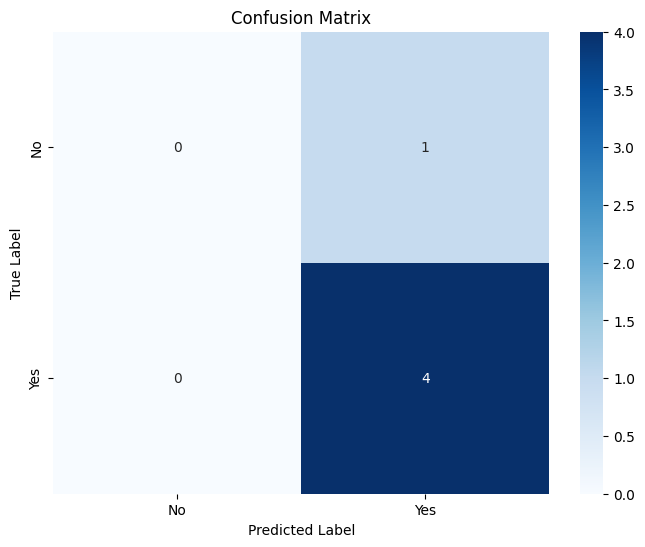

In [10]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()